In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
print(chars)
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s,i in stoi.items()}
print(itos)
vocab_size = len(itos)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### build the dataset

In [5]:
device = torch.device('cpu')
# device = torch.device('cuda')

In [6]:
block_size = 8
def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X).to(device)
    Y = torch.tensor(Y).to(device)
    print(X.dtype, X.shape, Y.dtype, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])        # 80%
Xdev, Ydev = build_dataset(words[n1:n2])    # 10%
Xte, Yte = build_dataset(words[n2:])        # 10%

torch.int64 torch.Size([182625, 8]) torch.int64 torch.Size([182625])
torch.int64 torch.Size([22655, 8]) torch.int64 torch.Size([22655])
torch.int64 torch.Size([22866, 8]) torch.int64 torch.Size([22866])


In [7]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


### custom layers using pytorch

In [8]:
class Linear:
    def __init__(self, fanin, fanout, bias=True, device='cpu') -> None:
        self.W = torch.randn((fanin, fanout), device=device) / fanin**0.5
        self.b = torch.zeros(fanout) if bias else None

    def to(self, device):
        self.W = self.W.to(device)
        if self.b is not None:
            self.b = self.b.to(device)
        return self

    def __call__(self, x) -> torch.tensor:
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b          
        return self.out    

    def parameters(self) -> list:
        params = [self.W] + ([self.b] if self.b is not None else [])
        return params

class BatchNorm1D:
    def __init__(self, dim, eps=1e-5, momentum=0.1, device='cpu') -> None:
        self.gamma = torch.ones(dim, device=device)
        self.beta = torch.zeros(dim, device=device)
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.running_mean = torch.zeros(dim, device=device)
        self.running_var = torch.ones(dim, device=device)
    
    def to(self, device):
        self.gamma = self.gamma.to(device)
        self.beta = self.beta.to(device)
        self.running_mean = self.running_mean.to(device)
        self.running_var = self.running_var.to(device)
        return self

    def __call__(self, x) -> torch.tensor:
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim=dim, keepdim=True)
            xvar = x.var(dim=dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean)/torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        params = [self.gamma, self.beta]
        return params
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def to(self, device):
        return self
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, fanin, fanout, device='cpu') -> None:
        self.W = torch.randn((fanin, fanout), device=device) / fanin**0.5
    
    def to(self, device):
        self.W = self.W.to(device)
        return self

    def __call__(self, x) -> torch.tensor:
        self.out = self.W[x]
        return self.out    
    
    def parameters(self):
        return [self.W]    

class FlattenConsecutive:
    def __init__(self, n) -> None:
        self.n = n

    def to(self, device):
        return self
    
    def __call__(self, x) -> torch.tensor:
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1: x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers) -> None:
        self.layers = layers
    
    def to(self, device):
        for layer in self.layers:
            layer.to(device)
        return self
    
    def __call__(self, x) -> torch.tensor:
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self) -> list:
        params = [p for layer in self.layers for p in layer.parameters()]
        return params

### implementing n/w using the custom layers

In [9]:
torch.manual_seed(42)

n_embd = 24
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(2*n_embd, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(2*n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(2*n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
    ])#.to(device)

with torch.no_grad():
    model.layers[-1].W *= 0.1
    # model.layers[-1].weight *= 0.1

print(sum(p.nelement() for p in model.parameters()))
for p in model.parameters():
    p.requires_grad = True

76579


In [10]:
g = torch.Generator().manual_seed(2147483647)
batch_size = 4
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g).to(device)
Xb = Xtr[ix]
Yb = Ytr[ix]
out = model(Xb)
print(out.shape)

torch.Size([4, 27])


In [11]:
#torch.manual_seed(42)
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in model.parameters():
        p.grad = None
    loss.backward()

    # update gradient
    lr = 0.1 if i < 150000 else 0.01
    for p in model.parameters():
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0 or i == max_steps-1: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    #break

      0/ 200000: 3.3167


  10000/ 200000: 2.0749
  20000/ 200000: 2.1020
  30000/ 200000: 2.6667
  40000/ 200000: 2.1537
  50000/ 200000: 1.7197
  60000/ 200000: 2.2295
  70000/ 200000: 1.8731
  80000/ 200000: 1.7196
  90000/ 200000: 1.9765
 100000/ 200000: 1.7598
 110000/ 200000: 2.0315
 120000/ 200000: 1.6305
 130000/ 200000: 1.7177
 140000/ 200000: 1.9628
 150000/ 200000: 1.8360
 160000/ 200000: 1.7166
 170000/ 200000: 1.5738
 180000/ 200000: 1.7398
 190000/ 200000: 2.0010
 199999/ 200000: 1.9260


In [34]:
torch.save(model, 'makemore_wavenet.pt')

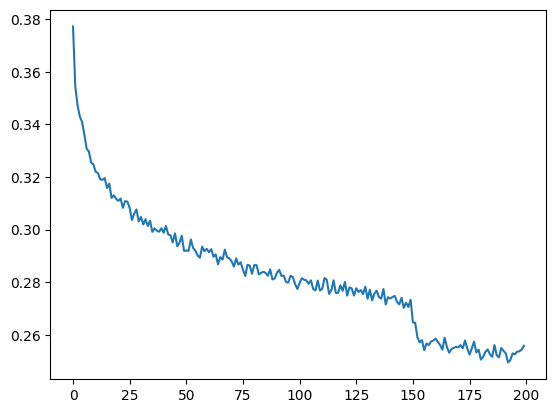

In [12]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [15]:
for layer in model.layers:
    layer.training = False
    # for p in layer.parameters():
    #     print(layer.__class__.__name__, p.nelement())

In [16]:
@torch.no_grad() # disable gradient tracking
def split_loss(split):
    x, y = {'train': (Xtr, Ytr),
            'val': (Xdev, Ydev),
            'test': (Xte, Yte)}[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7697029113769531
val 1.9895057678222656


In [33]:
torch.manual_seed(42)
for _ in range(10):
    x = [0]*block_size
    out = []
    while True:
        logits = model(torch.tensor(x, dtype=torch.long).reshape((1, -1)))
        counts = logits.exp()
        p = counts / counts.sum(dim=1, keepdim=True)
        ix = torch.multinomial(p, num_samples=1, replacement=True).item()
        out.append(itos[ix])
        if ix == 0:
            break
        x = x[1:] + [ix]
    print(''.join(out[:-1]))

yessy
havilynn
legolin
maryda
trysten
hendersen
patrice
abdihas
louisophael
kimpur
